In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, norm

In [2]:
# Load the Excel file and process data
file_path = 'Output_Parameters_Assembly.xlsx'
sheet_name = 'TopHatLeftRightTwist'
df = pd.read_excel(file_path, sheet_name=sheet_name)

In [3]:
def process_data(value):
    value = value.replace('.xlsx', '')
    value = re.sub(r'(T|S|B|590|-)', '', value)
    split_data = re.split(r'(_|(?<=[a-zA-Z])(?=\d)|(?<=\d)(?=[a-zA-Z]))', value)
    split_data = [x for x in split_data if x not in ['_', '']]
    return split_data

In [16]:
# Apply processing function to the input column
df['Processed_Column'] = df.iloc[:, 0].apply(process_data)

# Extract numerical values from the Processed_Column and convert them to features
def extract_numeric_features(row):
    return [
        float(x) if x.isdigit() or x.replace('.', '', 1).isdigit() 
        else 100 if x == "DP" 
        else 200 if x == "AlNumi" 
        else 0  # default case for other non-numeric values
        for x in row
    ]


# Apply the function to create numerical features
X = df['Processed_Column'].apply(extract_numeric_features)

# Convert the feature list to a DataFrame (input matrix X)
X = pd.DataFrame(X.tolist())

# Output target column (Zone Size (mm))
y = df['Twist Angle (Degrees)']
print("X = T_S_50_100DP590_100_52.5_15400-B_S_50_100AlNumi_150_50_25400_1" + str(X))

X = T_S_50_100DP590_100_52.5_15400-B_S_50_100AlNumi_150_50_25400_1        0      1    2      3     4        5     6      7    8      9     10  \
0     50.0  100.0  100  100.0  52.5  15400.0  50.0  100.0  200  150.0  50.0   
1     45.0  100.0  200  150.0  57.5  35400.0  55.0  100.0  200  100.0  60.0   
2     55.0  100.0  100  100.0  53.0  25400.0  50.0  100.0  200  200.0  55.0   
3     60.0  100.0  200  200.0  49.0  15400.0  45.0  100.0  200  200.0  45.0   
4     50.0  100.0  200  200.0  48.5  25400.0  45.0  100.0  200  150.0  50.0   
...    ...    ...  ...    ...   ...      ...   ...    ...  ...    ...   ...   
999   55.0  100.0  200  100.0  63.0  25400.0  60.0  100.0  200  200.0  50.0   
1000  45.0  100.0  100  150.0  58.0  25400.0  55.0  100.0  200  150.0  45.0   
1001  55.0  100.0  200  150.0  53.0  25400.0  50.0  100.0  100  150.0  55.0   
1002  45.0  100.0  200  100.0  47.5  25400.0  45.0  100.0  200  150.0  60.0   
1003  50.0  100.0  100  150.0  58.0  15400.0  55.0  100.0  200  1

In [17]:
# Step 5: Remove the 2nd and 8th columns from X (Note: Python is 0-indexed)
X = X.drop(columns=[1,6,7,8,9,10,11,12]) 
X.columns = [
    "Channel_Width_T",
    "material 100:DP590 200:AlNumi_T",
    "Thickness_T",
    "Draw_Depth_T",
    "Blank_Holding_Force_T"
]
print(X)

      Channel_Width_T  material 100:DP590 200:AlNumi_T  Thickness_T  \
0                50.0                              100        100.0   
1                45.0                              200        150.0   
2                55.0                              100        100.0   
3                60.0                              200        200.0   
4                50.0                              200        200.0   
...               ...                              ...          ...   
999              55.0                              200        100.0   
1000             45.0                              100        150.0   
1001             55.0                              200        150.0   
1002             45.0                              200        100.0   
1003             50.0                              100        150.0   

      Draw_Depth_T  Blank_Holding_Force_T  
0             52.5                15400.0  
1             57.5                35400.0  
2             5

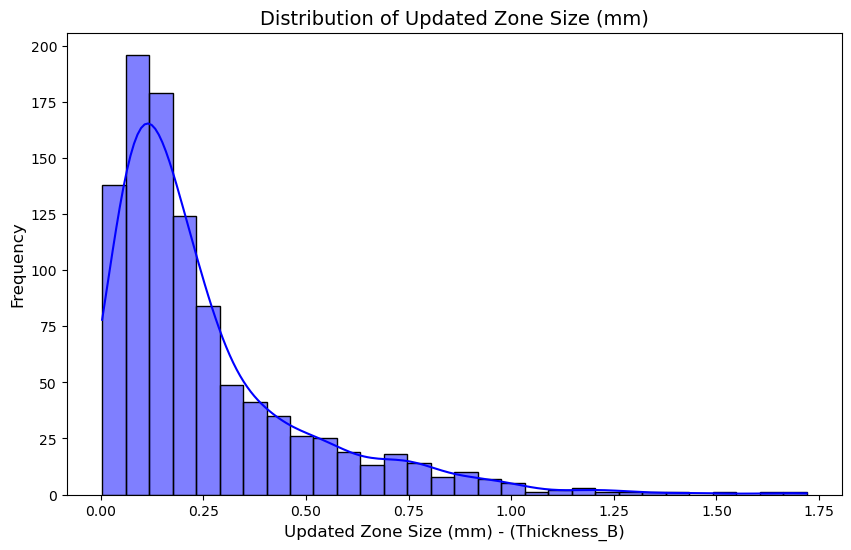

In [18]:
y_updated = y # substracting the thickness of the hat sheet and the flat sheet

# Step 2: Plot the distribution of the updated y
plt.figure(figsize=(10, 6))

# Plotting the histogram and KDE of the updated y
sns.histplot(y_updated, kde=True, bins=30, color='blue')

# Adding labels and title
plt.xlabel('Updated Zone Size (mm) - (Thickness_B)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Updated Zone Size (mm)', fontsize=14)

# Show the plot
plt.show()

Training Loss (MSE): 0.04682796551513137
Test Loss (MSE): 0.045854831029018626


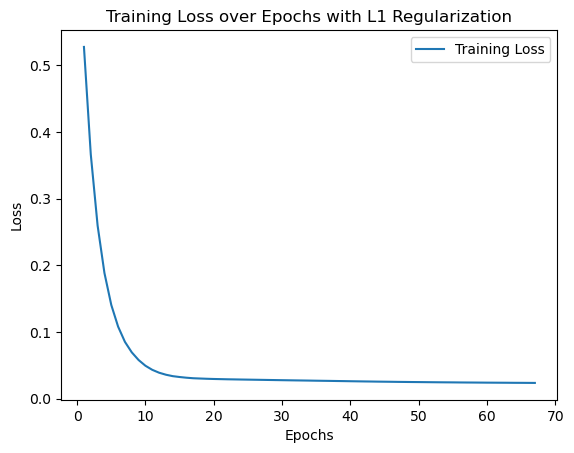

Test MSE: 0.045854831029018626


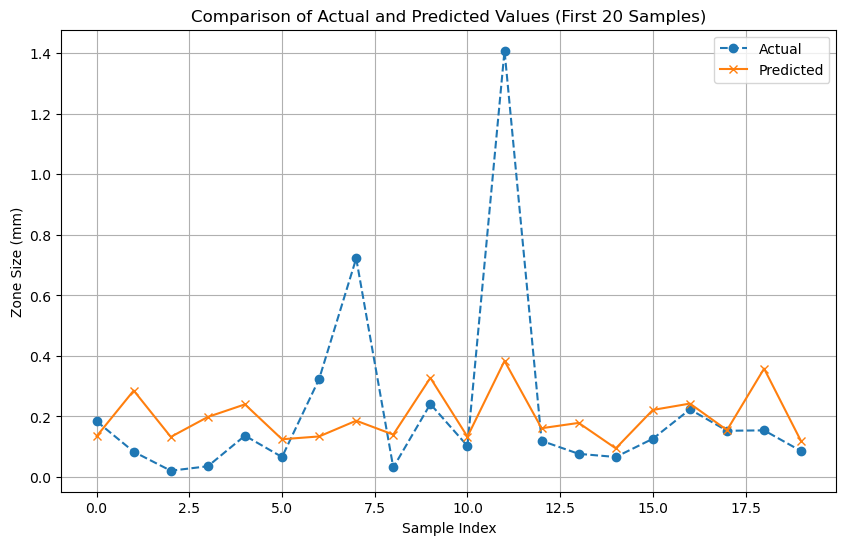

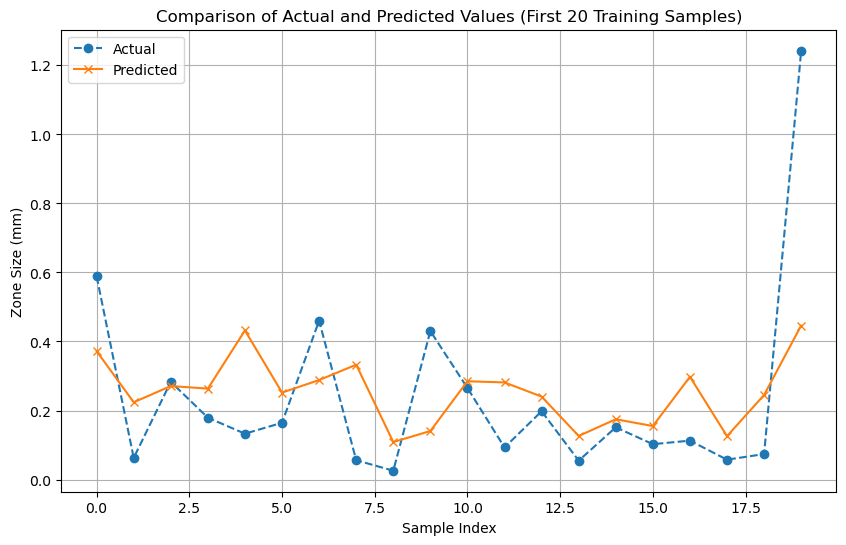

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet

# Train-test split (90:10)
X_train, X_test, y_train, y_test = train_test_split(X, y_updated, test_size=0.1, random_state=42)

# Feature scaling for input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPRegressor(hidden_layer_sizes=(20,20,20,20,20),
                   activation='relu',
                   solver='adam',
                   max_iter=1500,
                   random_state=42,
                   #alpha=0.0001,  # L2 regularization
                   #early_stopping=False,  # Enable early stopping
                   #validation_fraction=0.1,  # Use 10% of training data for validation
                   #n_iter_no_change=10 
                  ) 

# Train the model
mlp.fit(X_train_scaled, y_train)

# Predictions and performance evaluation
y_train_pred = mlp.predict(X_train_scaled)
y_test_pred = mlp.predict(X_test_scaled)

# Calculate Mean Squared Error
train_loss = mean_squared_error(y_train, y_train_pred)
test_loss = mean_squared_error(y_test, y_test_pred)

print(f"Training Loss (MSE): {train_loss}")
print(f"Test Loss (MSE): {test_loss}")

# Plot training loss over epochs
epochs = np.arange(1, len(mlp.loss_curve_) + 1)

plt.plot(epochs, mlp.loss_curve_, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs with L1 Regularization')
plt.legend()
plt.show()

# Evaluate model performance on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {mse_test}")
# Plot first 20 predicted vs actual values for the test set
y_test_pred_20 = y_test_pred[:20]
y_test_20 = y_test[:20].values

plt.figure(figsize=(10, 6))
plt.plot(y_test_20, label='Actual', marker='o', linestyle='--')
plt.plot(y_test_pred_20, label='Predicted', marker='x', linestyle='-')
plt.xlabel('Sample Index')
plt.ylabel('Zone Size (mm)')
plt.title('Comparison of Actual and Predicted Values (First 20 Samples)')
plt.legend()
plt.grid(True)
plt.show()
# Plot first 20 predicted vs actual values for the training set
y_train_pred_20 = y_train_pred[:20]
y_train_20 = y_train[:20].values

plt.figure(figsize=(10, 6))
plt.plot(y_train_20, label='Actual', marker='o', linestyle='--')
plt.plot(y_train_pred_20, label='Predicted', marker='x', linestyle='-')
plt.xlabel('Sample Index')
plt.ylabel('Zone Size (mm)')
plt.title('Comparison of Actual and Predicted Values (First 20 Training Samples)')
plt.legend()
plt.grid(True)
plt.show()

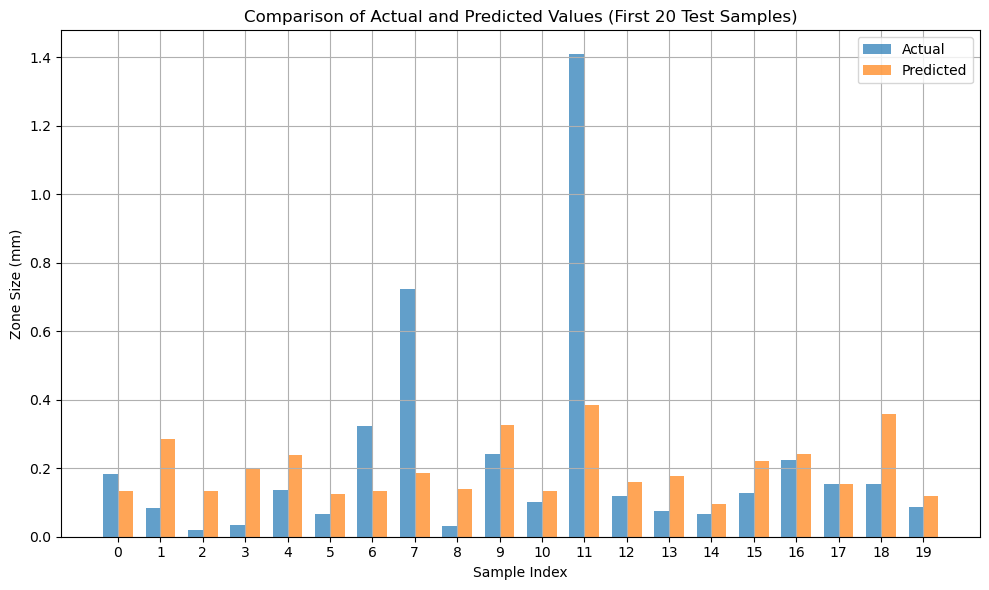

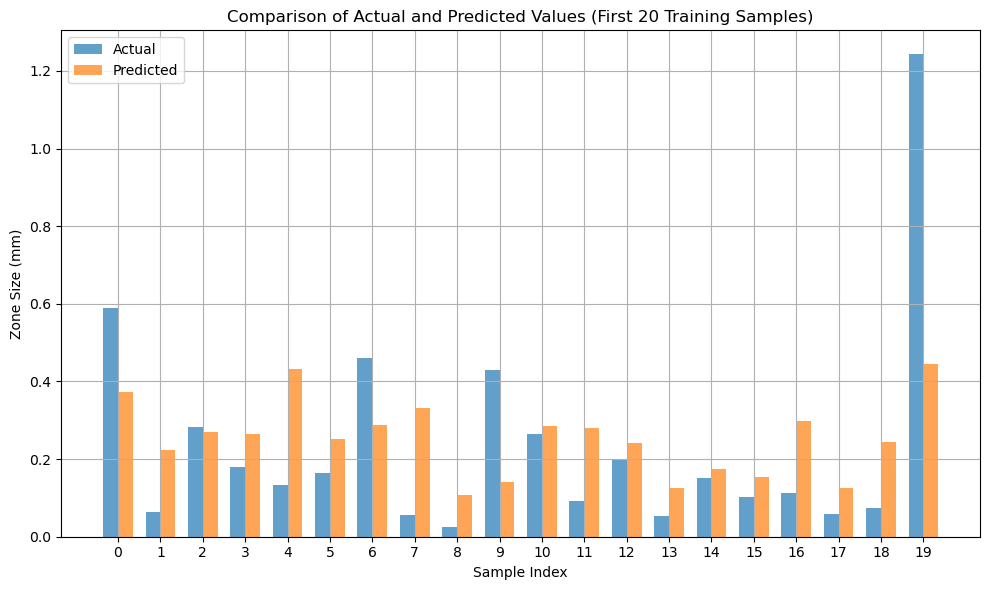

In [23]:
# Comparison of Actual and Predicted Values (First 20 Test Samples)
y_test_pred_20 = y_test_pred[:20]
y_test_20 = y_test[:20].values
index = np.arange(len(y_test_20))  # Creating an index for each sample

plt.figure(figsize=(10, 6))
bar_width = 0.35  # Width of the bars

# Plotting bars for actual and predicted values
plt.bar(index, y_test_20, bar_width, label='Actual', alpha=0.7)
plt.bar(index + bar_width, y_test_pred_20, bar_width, label='Predicted', alpha=0.7)

# Labels and title
plt.xlabel('Sample Index')
plt.ylabel('Zone Size (mm)')
plt.title('Comparison of Actual and Predicted Values (First 20 Test Samples)')
plt.xticks(index + bar_width / 2, index)  # Setting the x-axis tick positions and labels
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Comparison of Actual and Predicted Values (First 20 Training Samples)
y_train_pred_20 = y_train_pred[:20]
y_train_20 = y_train[:20].values
index_train = np.arange(len(y_train_20))

plt.figure(figsize=(10, 6))

# Plotting bars for actual and predicted values in the training set
plt.bar(index_train, y_train_20, bar_width, label='Actual', alpha=0.7)
plt.bar(index_train + bar_width, y_train_pred_20, bar_width, label='Predicted', alpha=0.7)

# Labels and title
plt.xlabel('Sample Index')
plt.ylabel('Zone Size (mm)')
plt.title('Comparison of Actual and Predicted Values (First 20 Training Samples)')
plt.xticks(index_train + bar_width / 2, index_train)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Using 903 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

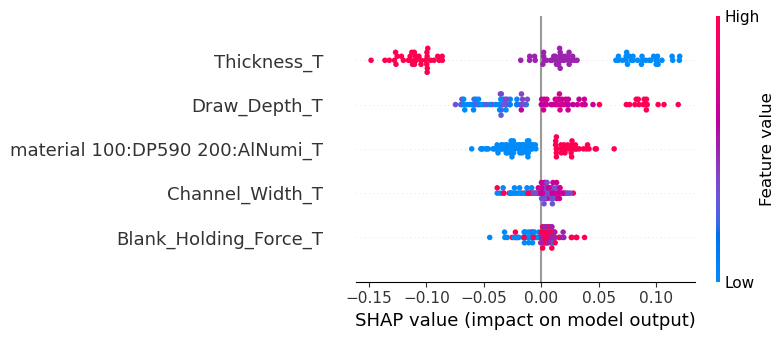

In [22]:
import shap
import matplotlib.pyplot as plt

# Initialize the SHAP explainer with the trained neural network model
explainer = shap.KernelExplainer(mlp.predict, X_train_scaled)

# Calculate SHAP values for the test set (or a subset if it's large)
shap_values = explainer.shap_values(X_test_scaled[:100])  # Limit to first 100 samples for faster computation

# Summary plot of SHAP values (shows overall feature importance)
shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=X.columns)

# Detailed force plot for the first test sample (explanation of individual prediction)
shap.force_plot(explainer.expected_value, shap_values[0], X_test_scaled[0], feature_names=X.columns)